# Reading in Environment Agency rain gauge data (15 min)

### Notes
- Intense QC code read in, not sure how easy that will be, I had to clone it off Github and change line 10 of code as got an error with a package, proabbly due to Python versions. Think the package needs updating on Github but not sure who is still in charge of maintaining it. Need ETCCDI data (available in example data for Intense QC)


### What does the code do

### What does the code need to do?
1. Download the data
    - Try historic API
    - Try real-time API
    - Save data
2. Quality control data
    - Use intense-qc code
    - Remove failed gauges
    - Remove failed observations
    - Save Qc'ed data
3. Grid data
    - Save gridded data
4. Clip to domains
    - SHETRAN 
    - HIPIMS
    - Save

In [17]:
# Import relevent packages
import pandas as pd
import numpy as np
import requests
from os.path import join, exists
import os
from datetime import datetime
import io

In [18]:
##### Inputs to change
start_date = "2023-06-20"
end_date = "2023-06-30"

out_path = r"C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\PYRAMID\data\realtime"

# Bounding box for data 
e_l, n_l, e_u, n_u = [355000, 534000, 440000, 609000]
bbox = [e_l, e_u, n_l, n_u]

In [19]:
ea_outpath = join(out_path, "EA")
if not exists(ea_outpath):
    os.mkdir(ea_outpath)

# Get list of rainfall stations
root = "http://environment.data.gov.uk/flood-monitoring"
response = requests.get(root + "/id/stations?parameter=rainfall")
r = response.json()["items"]
df = pd.json_normalize(r)

# Get stations in area
extent_stations = df.loc[(df.northing > n_l) & (df.northing < n_u) & (df.easting > e_l) & (df.easting < e_u)]
station_ids = extent_stations.stationReference.to_list()
names = np.array(extent_stations.stationReference + "_" + extent_stations.easting.astype(int).astype(
    str) + "_" + extent_stations.northing.astype(int).astype(str) + ".csv")

now = datetime.now()
# use real-time API if possible (last 28 days)
if now - pd.to_datetime(start_date) < pd.Timedelta("28d"):
    for i, station in enumerate(station_ids):
        try:
            path = "http://environment.data.gov.uk/flood-monitoring/id/measures/{id}-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?parameter=rainfall&startdate={startDate}&enddate={endDate}"
            path = path.replace("{id}", station)
            path = path.replace("{startDate}", start_date)
            path = path.replace("{endDate}", end_date)
            path = path.replace("{startTime}", start_date)

            response = requests.get(path)
            r = response.json()["items"]
            df = pd.json_normalize(r)
            if len(df) > 0:
                data = pd.Series(df.value.values, index=pd.to_datetime(df.dateTime))
                data.to_csv(join(ea_outpath, names[i]))
        except:
            print(station, "not worked.")

# if not use historical API (seems to only work for last year- not very historical)
else:
    dates = pd.date_range(start_date, end_date)
    iids = np.array(extent_stations.measures.str[0].str["@id"])

    for date_ts in dates:
        date = str(date_ts).split(" ")[0]
        path = "http://environment.data.gov.uk/flood-monitoring/archive/readings-full-{date}.csv"
        path = path.replace("{date}", str(date))
        r = requests.get(path)
        full_data = []
        if r.status_code == 200:
            df = pd.read_csv(io.StringIO(r.text), index_col=0, parse_dates=True)
            full_data.append(df[[measure in iids for measure in df.measure]])
    full_data = pd.concat(full_data).groupby("stationReference")

    for i, station in enumerate(station_ids):
        try:
            full_data.get_group(station).value.to_csv(join(ea_outpath, names[i]))
        except:
            print(station, "not worked.")

In [20]:
# Import relevent packages
import os
from os.path import join
import pandas as pd
os.sys.path.append(r"C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\Jupyter\intense-qc")
from intense import gauge, qc, utils
from pyproj import Transformer

In [26]:
### Inputs to change
#out_path = r"C:\Users\Amy\OneDrive - Newcastle University\Documents\PYRAMID\data\event\test"
gauge_path = join(out_path, "EA")
etccdi_data_folder = r"C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\Jupyter\intense-qc\tests\etccdi_data"

gauge_files = [f for f in os.listdir(gauge_path) if f.endswith(".csv")]

gauges = {}
gauges1h = {}

for g in gauge_files:
    name = g[0:-4]
    data = pd.read_csv(join(gauge_path, g), index_col=0, parse_dates=True).iloc[:, 0]
    data = data.sort_index()
    res_min = pd.Series(data.dropna().index).diff().median().seconds / 60
    
    try:
        if data.index.dtype == "datetime64[ns, UTC]":
            gauges1h[name] = data.resample("1h").sum()
            gauges[name] = data
        else:
            gauges1h[name] = data.resample("1h").sum().tz_localize('UTC')
            gauges[name] = data.tz_localize('UTC')
            
    except:
        print(name, "not read in.")

gauges1h = pd.DataFrame(gauges)
gauges1h = gauges1h.dropna(axis=0, how="all")
gauges = pd.DataFrame(gauges)

In [27]:
def get_gauge_flags(data, loc):
    '''Function to apply wokring Intense QC hourly checks on gauge data. 
    Args: data is the gauge data (pd.Series), loc is the gauge location (eastings, northings)
    Returns: flags as a dictionary {gauge flagged, years flagged, obs flagged}
    '''
    eastings, northings = loc
    # convert coordinates to lat/lon
    transformer = Transformer.from_crs("epsg:27700", "epsg:4326")
    latitude, longitude = transformer.transform(eastings, northings)

    # create gauge object
    rain_gauge = gauge.Gauge(
        station_id,
        path_to_original_data="",
        latitude=latitude,
        longitude=longitude,
        original_timestep="15min",
        original_units="mm/h",
        new_units="mm/h",
        new_timestep="1h",
        data=data
    )
    rain_gauge.get_info()

    # create qc object 
    test = qc.Qc(
        gauge=rain_gauge,
        etccdi_data_folder=etccdi_data_folder
    )

    # checks that don't work on existing data
    """
    test.check_percentiles()
    test.check_k_largest()
    test.check_intermittency()
    test.change_in_min_val_check() 
    test.cwd_check() # missing function in utils file???
    test.change_in_min_val_check() # Change in minimum value check, homogeneity check to see if the resolution of the data has changed. Change flag, flag years
    test.find_neighbours("hourly") # frequency: must be either hourly, daily or monthly, Names or names and paths of neighbouring stations
    # conditions are: must be within 50km, at least 3 years overlap, select the closest 10, don't have three years of data
    # check_hourly_neighbours(), check_daily_neighbours(), check_monthly_neighbours()
    test.get_flags() # runs all checks, fails at find_neighbours()
    """

    ### run checks ###

    flagged_sdii = 0
    sdii_thresh = 100 # just arbitrary atm
    if any(np.array(test.get_sdii()) > sdii_thresh): # Simple precipitation intensity index, SDII from ETCCDI and from gauge values (sdii_gridded, sdii_gauge), not sure how to use this
        flagged_sdii = 1
    
    # Flag data if any of these don't return 0:
    gauge_checks = [
        test.check_days_of_week(), # Checks if proportions of rainfall in each day is significantly different
        test.check_break_point(), # Pettitt breakpoint check
        flagged_sdii
    ]
    
    flagged_gauge = sum(gauge_checks) != 0
    #if flagged_gauge:
    #    print("Gauge", np.array(["days of week", "break point", "sdii"])[np.array(gauge_checks) == 1])
    #    print(test.check_break_point())

    # Flag individual data observations if don't return 0:
    obs_checks = pd.DataFrame(index=rain_gauge.data.index)
    obs_checks["world_record"] = test.world_record_check_ts() # Checks if and to what degree the world record has been exceeded by each rainfall value, 4, 3, 2 or 1 if exceeded by > 1.5x, 1.33x, 1.22x or 0x respectively and 0 if not exceeded for each value
    obs_checks["rx1day"] = test.rx1day_check_ts() # Checks hourly values against maximum 1-day precipitation, Magnitudes of exceedance for each day
    obs_checks["cdd"] = test.cdd_check() # ETCCDI provide an index for maximum length of dry spell. Look for suspicious number of consecutive dry hours recorded. Consecutive Dry Days: Maximum length of dry spell, maximum number of consecutive days with RR < 1mm. Magnitudes of exceedence of the length of longest dry period
    obs_checks["daily_accums"] = test.daily_accums_check() # Check daily accumulations. Suspect daily accumulations flagged where a recorded rainfall amount at these times is preceded by 23 hours with no rain. A threshold of 2x the mean wet day amount for the corresponding month is applied to increase thechance of identifying accumulated values at the expense of genuine, moderate events
    obs_checks["monthly_accums"] = test.monthly_accums_check() # Check monthly accumulations. Flags month prior to high value
    obs_checks["streaks"] = test.streaks_check() # Streaks: This is where you see the same value repeated in a run. Currently this records streaks of 2hrs in a row or more over 2 x Monthly mean rainfall. It is considered to be unlikely that you would see even 2 consecutive large rainfall amounts. For this code I have substituted the monthly mean rainfall for SDII as I want the thresholds to be independent of the rainfall time series as the global dataset is of highly variable quality.
    flagged_obs = obs_checks.index[obs_checks.sum(1) > 0]

    # Flags each individual year:
    year_flags = np.array([
        test.r99ptot_check_annual(), # Check against R99pTOT: R99pTOT. Annual total PRCP when RR > 99p. Magnitudes of exceedance for yearly 99th percentiles
        test.prcptot_check_annual() # check against annual total: PRCPTOT. Annual total precipitation in wet days. Magnitudes of exceedance for yearly totals
    ])

    flagged_years = np.arange(rain_gauge.data.index.min().year, rain_gauge.data.index.max().year + 1)[year_flags.sum(0) < 0]

    return({"gauge" : flagged_gauge, "years" : flagged_years, "obs" : flagged_obs})

In [28]:
qc_gauges = pd.DataFrame(index=gauges.index)
for i in range(len(gauges.columns)):

    col = gauges.columns[i]
    station_id, eastings, northings = col.split("_")

    data = gauges1h.iloc[:, i].dropna()
    loc = (eastings, northings)

    flags = get_gauge_flags(data, loc)

    # only include gauge data that is not flagged
    if not flags["gauge"]:

        # remove flagged observationns
        if len(flags["obs"]) < 0:
            qc_gauges[col] = gauges[col]    

        else:
            qc_gauges[col] = np.nan
            cond = [idx not in flags["obs"] for idx in gauges.index.round("1h")]
            qc_gauges.loc[cond, col] = gauges.loc[cond, col]

C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\Jupyter\intense-qc\intense\qc.py:817: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df1.append(df2)
C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\Jupyter\intense-qc\intense\qc.py:817: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df1.append(df2)
C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\Jupyter\intense-qc\intense\qc.py:817: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df1.append(df2)
C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\Jupyter\intense-qc\intense\qc.py:817: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = 

C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\Jupyter\intense-qc\intense\qc.py:817: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df1.append(df2)


In [30]:
qc_path = join(gauge_path, "qc")
if not exists(qc_path):
    os.mkdir(qc_path)

In [31]:
for col in qc_gauges.columns:
    data = qc_gauges`[col].dropna()
    if len(data) > 0:
        data.to_csv(join(qc_path, col + ".csv"))

### Gridding gauge data

In [1]:
import wradlib as wrl
import numpy as np
from os.path import join, exists
import pandas as pd
import h5py 
import matplotlib.pyplot as plt
import os
import wradlib.ipol as ipol
import matplotlib.pyplot as pl
import gstools as gs

In [2]:
##### Inputs to change
start_date = "2023-06-20"
end_date = "2023-06-30"

out_path = r"C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\PYRAMID\data\realtime"

# Bounding box for data 
e_l, n_l, e_u, n_u = [355000, 534000, 440000, 609000]
bbox = [e_l, e_u, n_l, n_u]

In [3]:
gridded_inpath = join(join(out_path, "EA"), "qc")
gridded_outpath = join(out_path, "gridded")
if not exists(gridded_outpath):
    os.mkdir(gridded_outpath)

gauge_colnames = [f.split(".")[0] for f in os.listdir(gridded_inpath) if f.endswith(".csv")]

gauge_files = [pd.read_csv(join(gridded_inpath, col + ".csv"), index_col=0) for col in gauge_colnames]

In [4]:
start_time = min([g.index.min() for g in gauge_files])
end_time = max([g.index.max() for g in gauge_files])

gauges = pd.DataFrame(index=pd.date_range(start_time, end_time, freq=str(15*60) + "s"))
g_x = np.empty(len(gauge_colnames))
g_y = np.empty(len(gauge_colnames))

for i, f in enumerate(gauge_colnames):
    
    g_x[i] = float(f.split("_")[-2])
    g_y[i] = float(f.split("_")[-1])
    
    ts = pd.to_datetime(gauge_files[i].index)
    data = gauge_files[i][f].values
    
    gauges[f] = np.nan
    gauges.loc[ts, f] = pd.Series(data, index=ts)

In [8]:
xs = np.arange(e_l, e_u, 1000)
ys = np.arange(n_l, n_u, 1000)

In [9]:
# Synthetic observations and source coordinates
src = np.vstack([g_x, g_y]).transpose()

# Target coordinates
xtrg = xs
ytrg = ys
trg = np.meshgrid(xtrg, ytrg)
trg = np.vstack((trg[0].ravel(), trg[1].ravel())).T

# Interpolation objects
ok = ipol.OrdinaryKriging(src, trg, remove_missing=True)
ok1 = ipol.OrdinaryKriging(src[0:-1, :], trg, remove_missing=True)

In [10]:
new_index = pd.date_range(start_date, end_date, freq=str(15*60) + "s")

In [26]:
gridded = np.full((len(new_index), len(ys), len(xs)), np.nan) # chekc dimensions correct way round

for t in range(len(new_index)):
    time = new_index[t]
    vals = gauges.loc[time].values
    tot = np.nansum(vals)

    if not np.isnan(tot):
        if tot == 0:
            gridded[t] = 0
        else:
            try:
                gridded[t] = np.flip(ok(vals).astype(float).reshape((len(ys), len(xs))), axis=0)
            except:
                pass        

C:\Users\Amy\AppData\Local\Temp\ipykernel_3820\4266260332.py:5: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  vals = gauges.loc[time].values


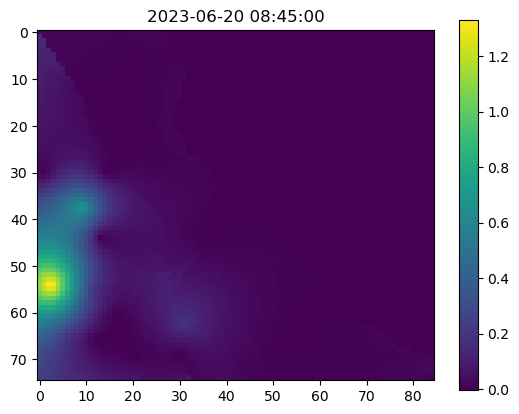

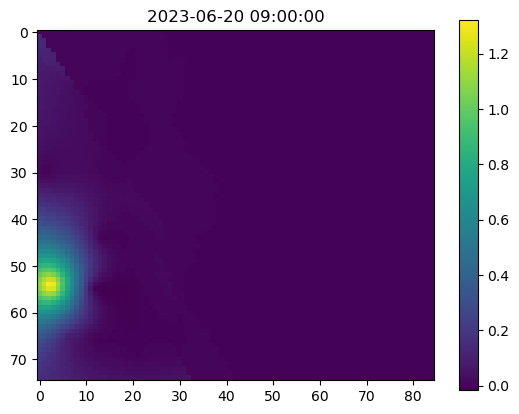

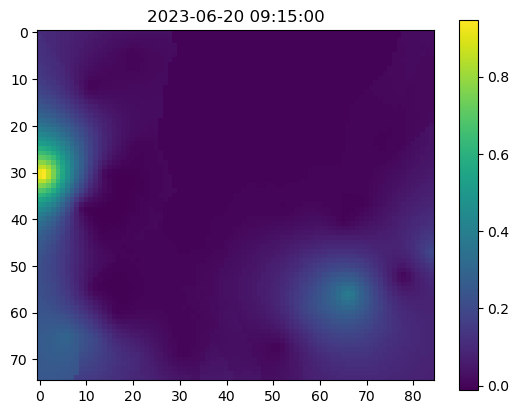

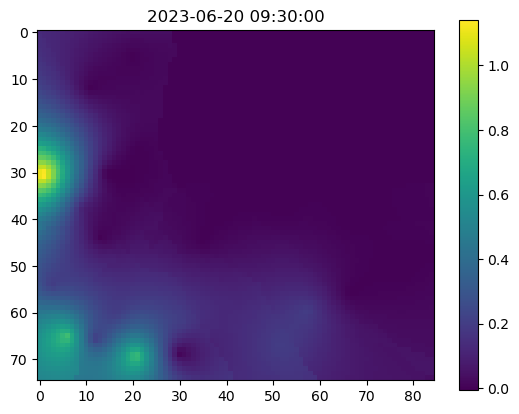

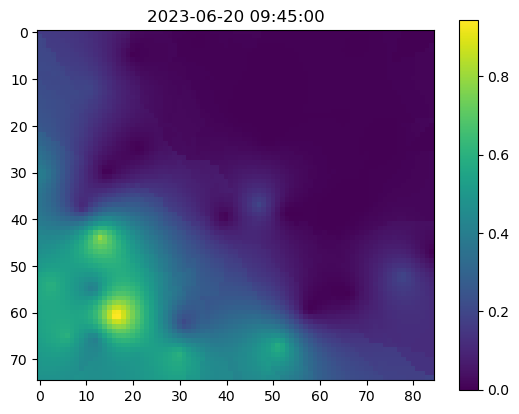

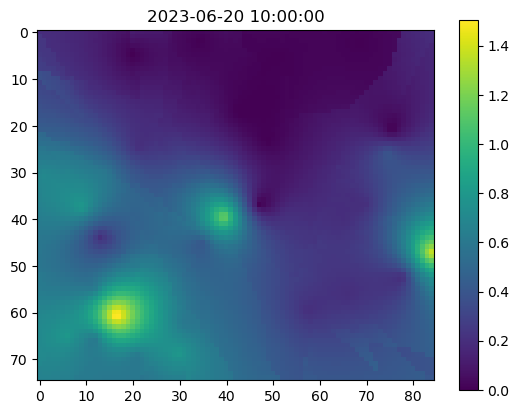

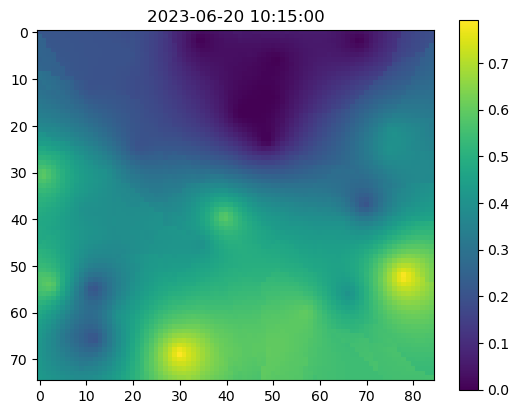

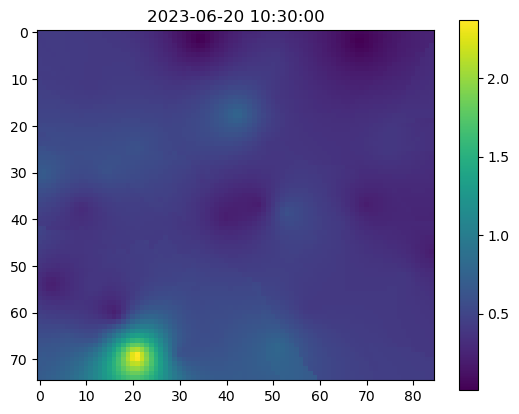

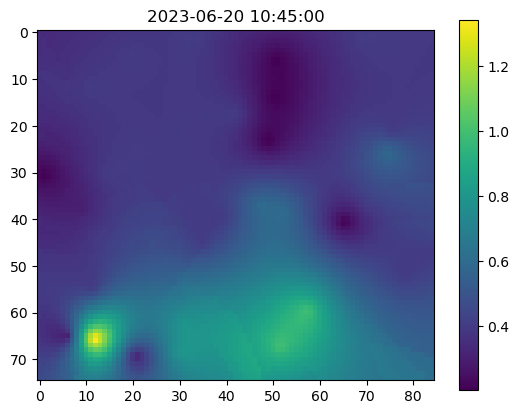

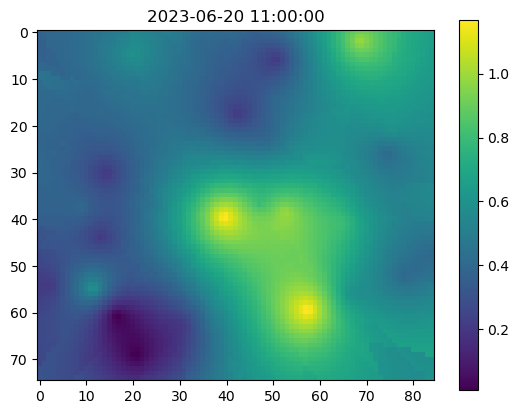

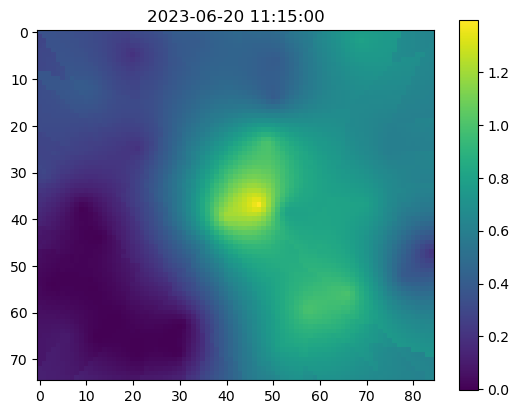

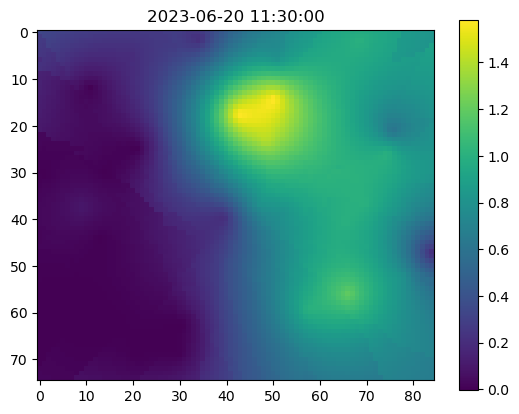

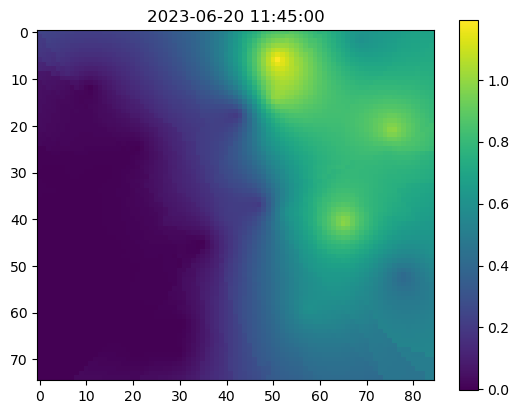

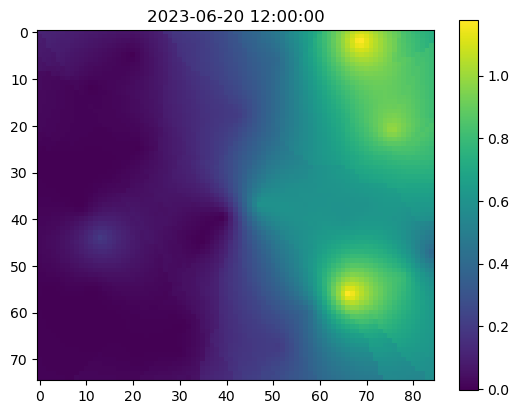

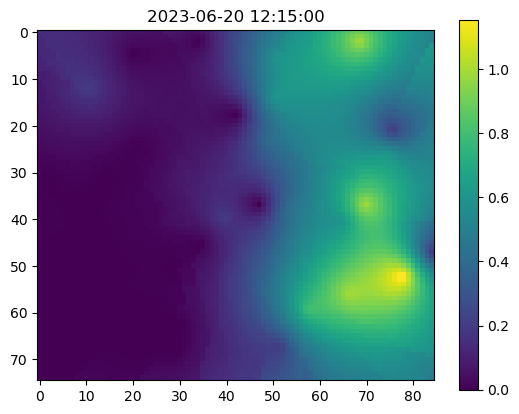

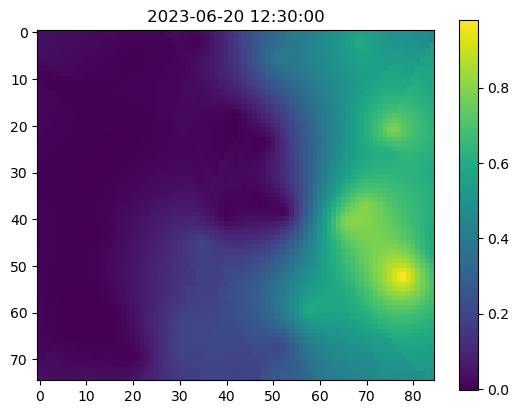

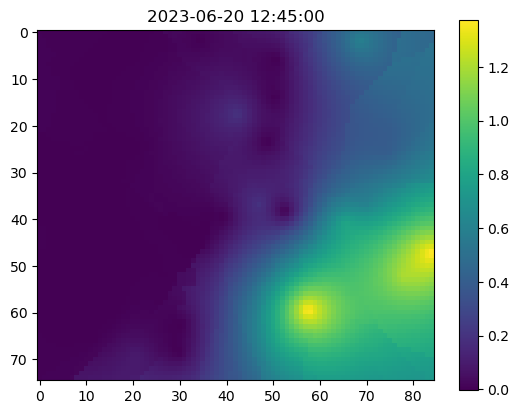

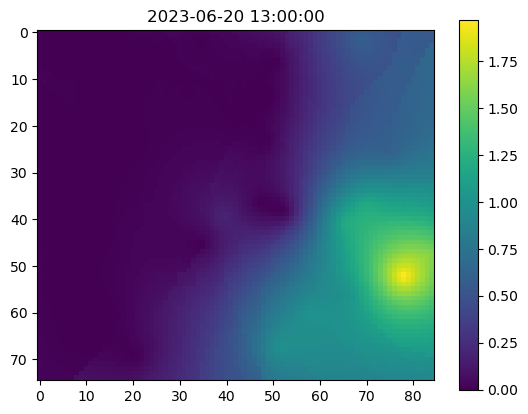

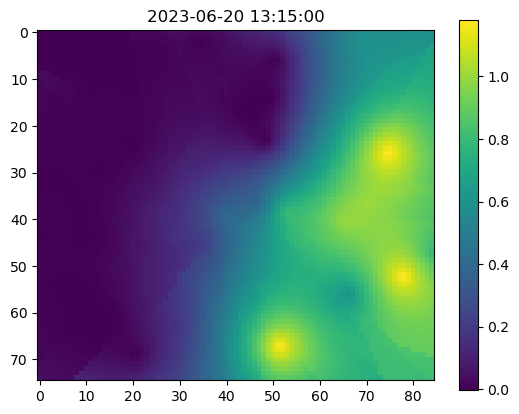

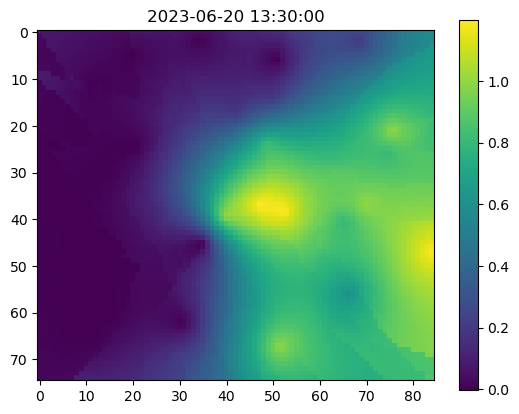

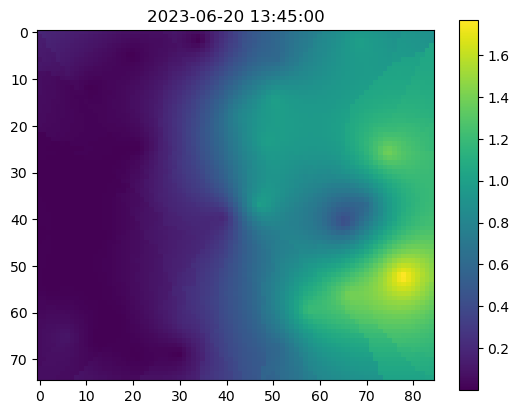

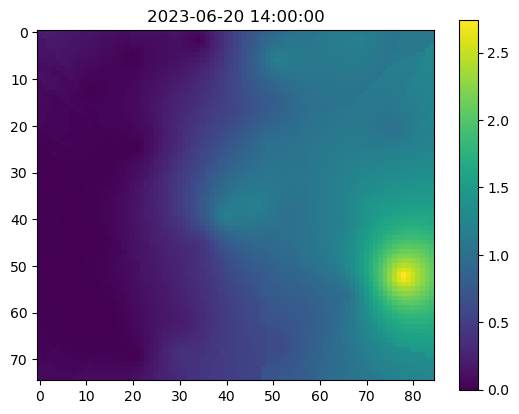

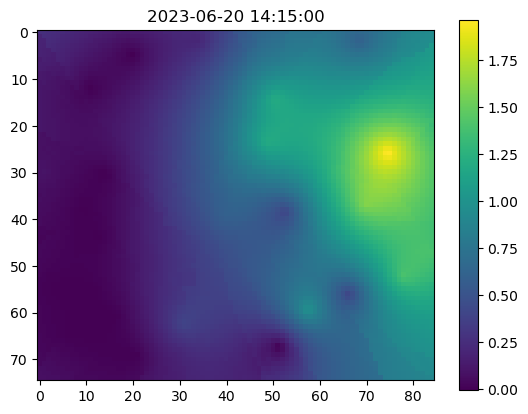

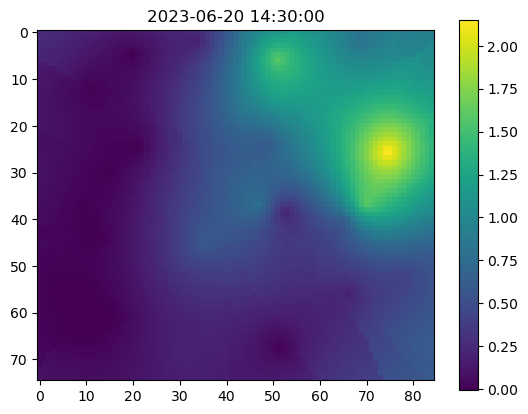

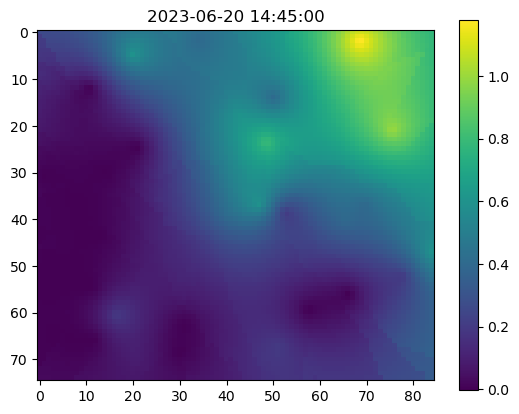

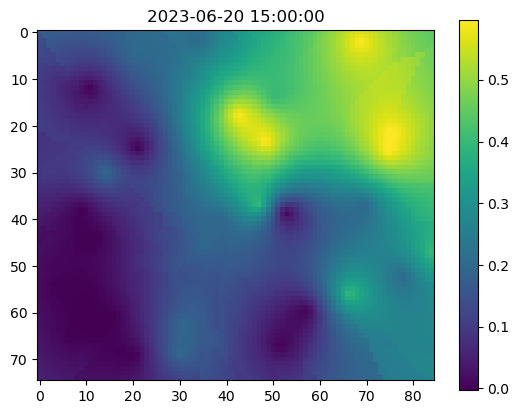

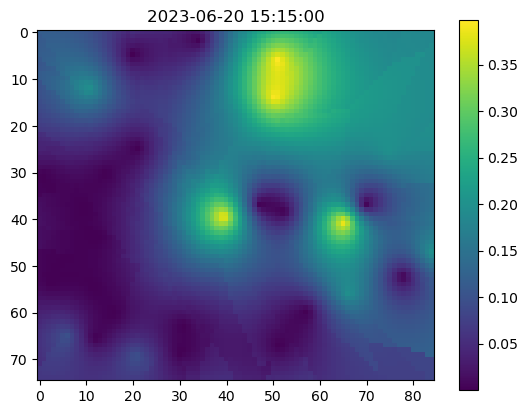

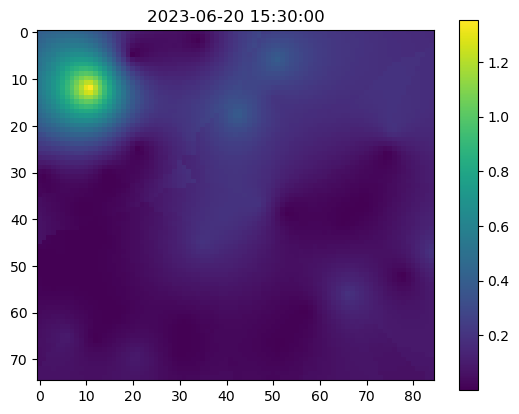

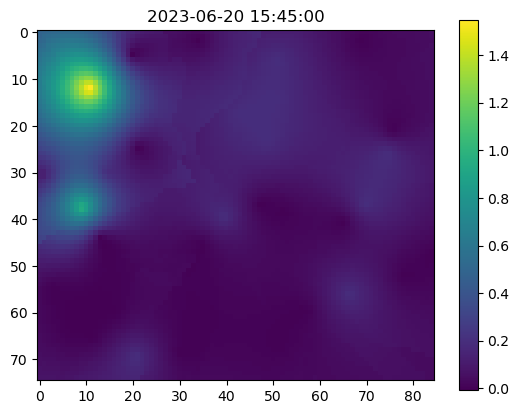

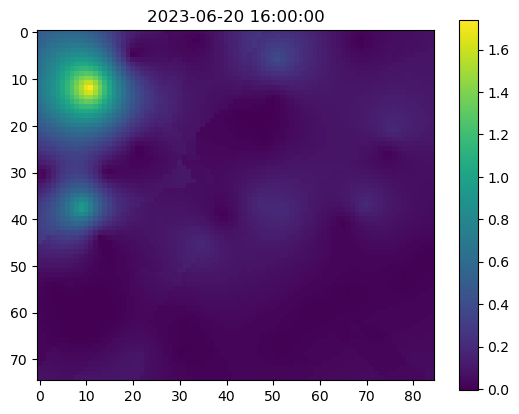

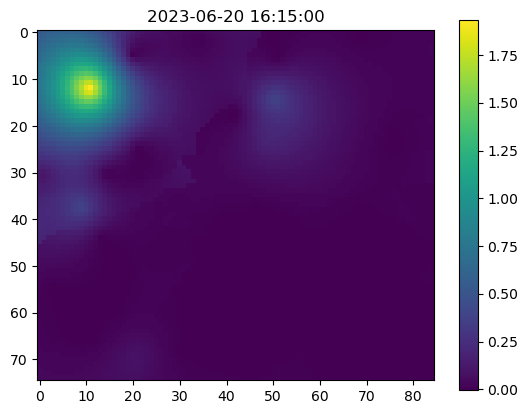

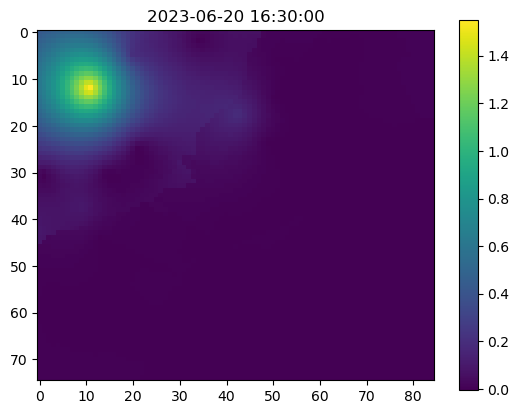

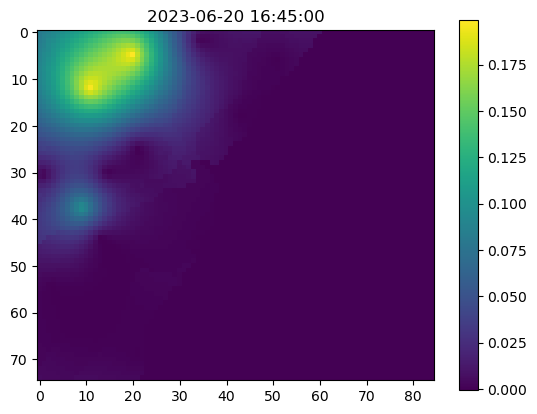

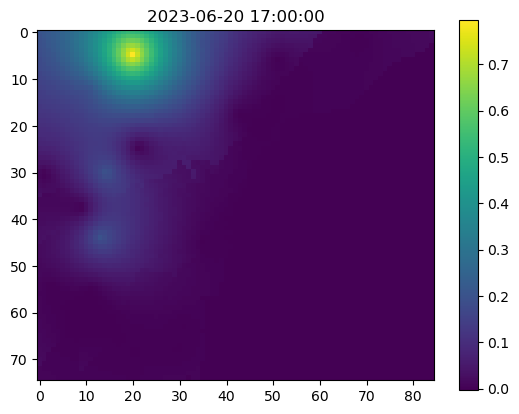

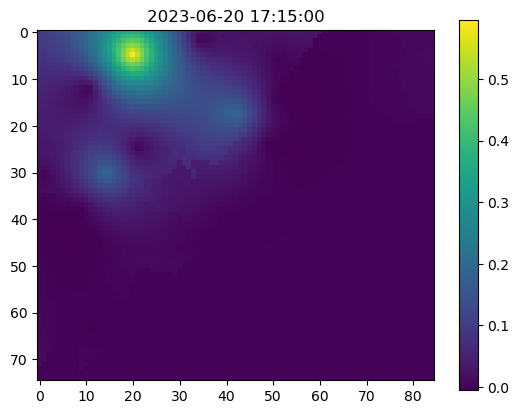

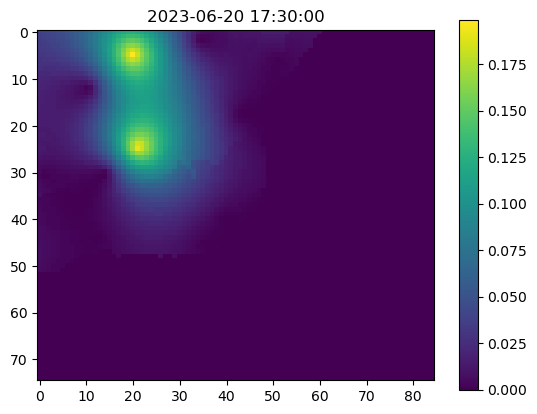

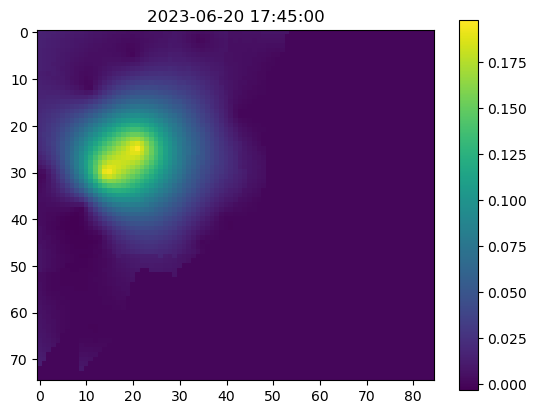

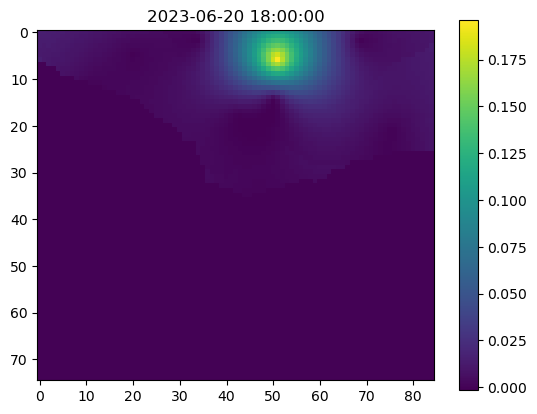

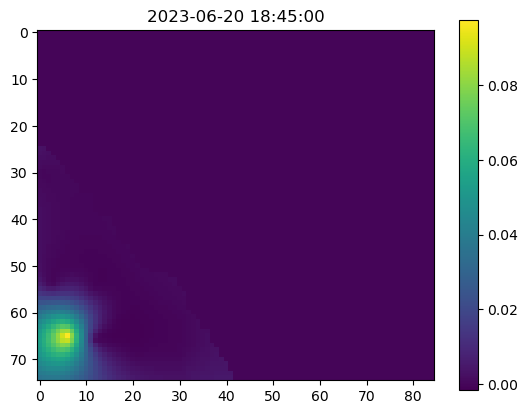

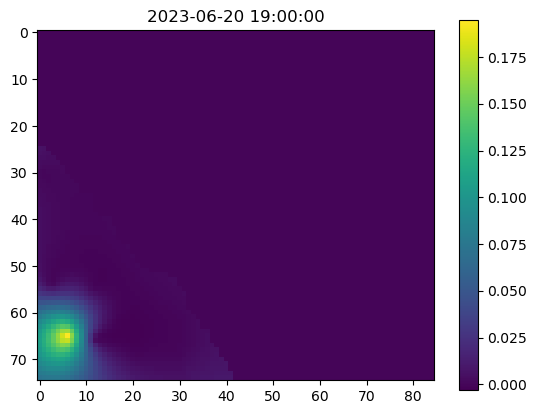

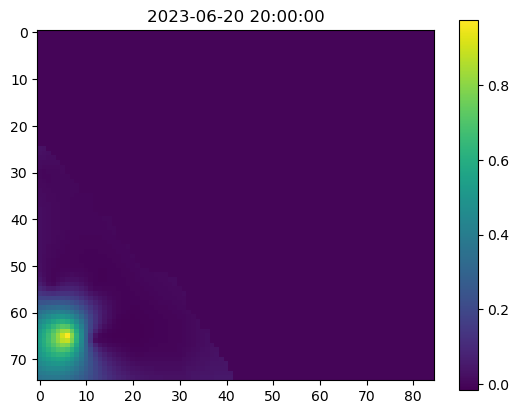

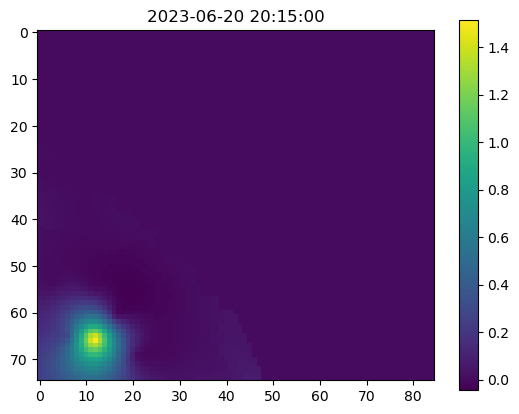

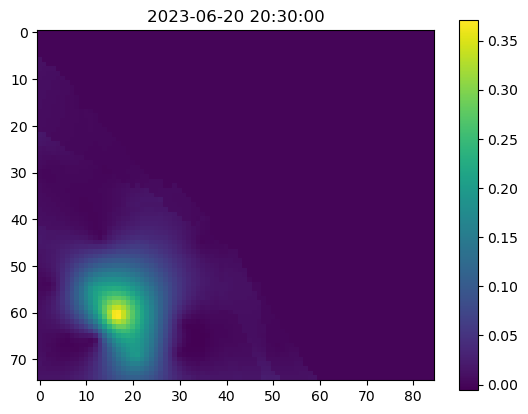

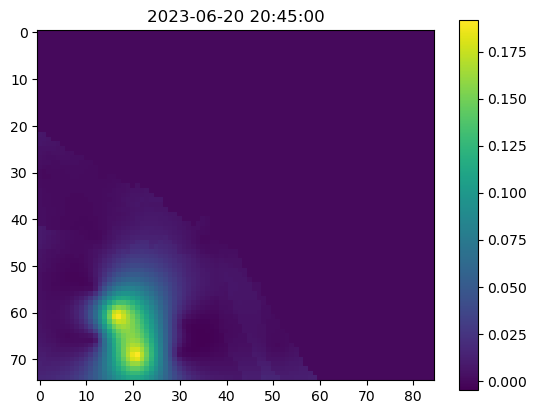

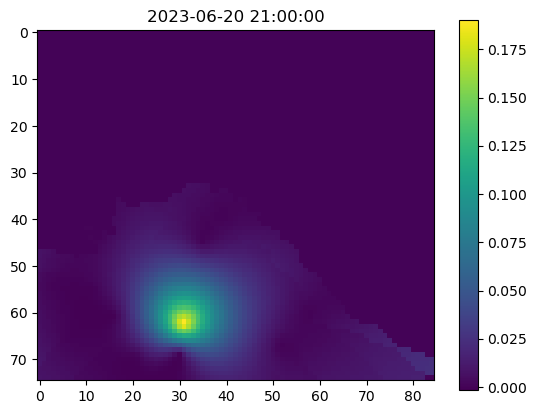

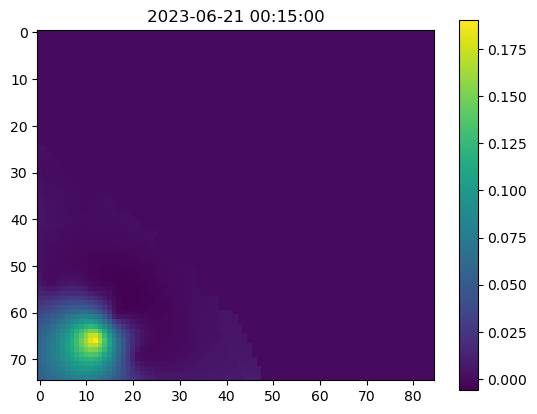

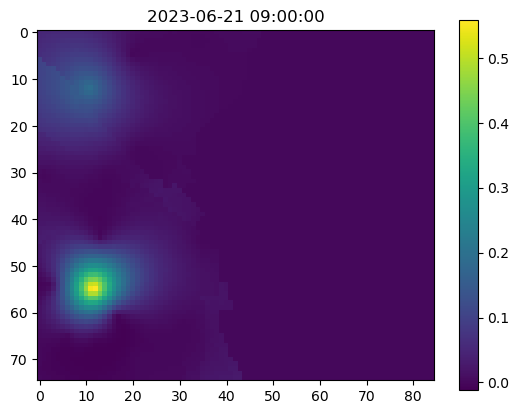

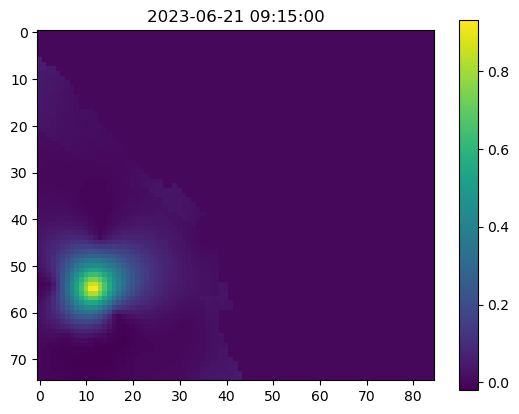

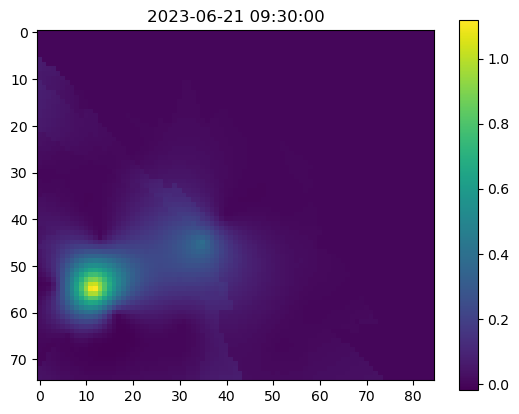

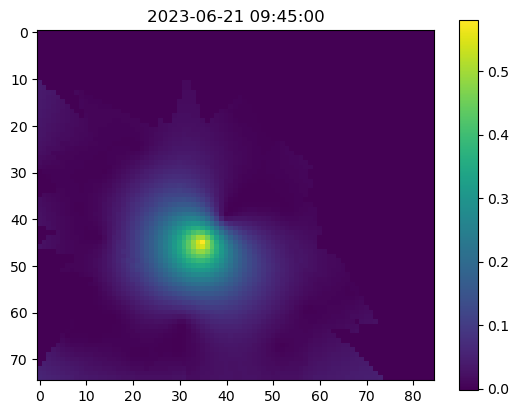

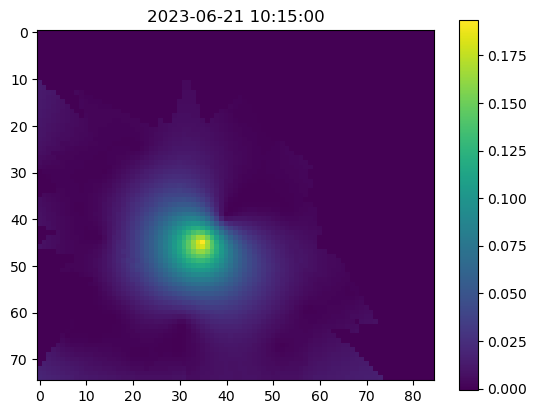

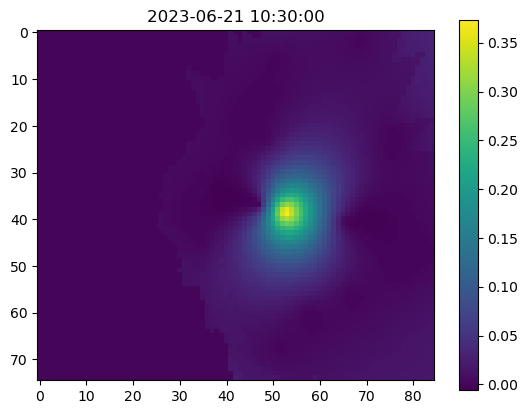

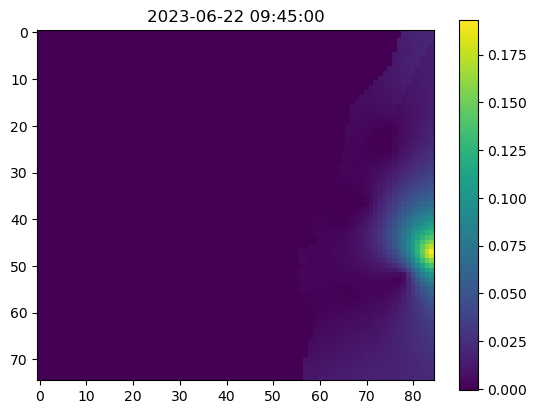

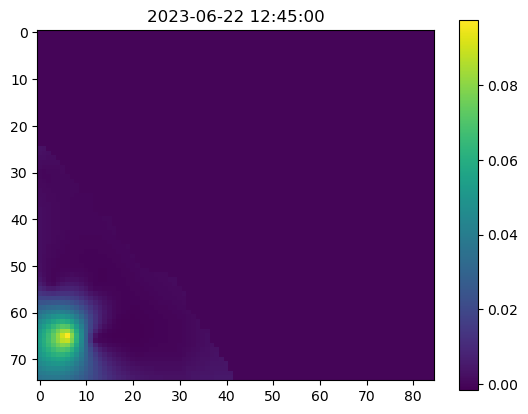

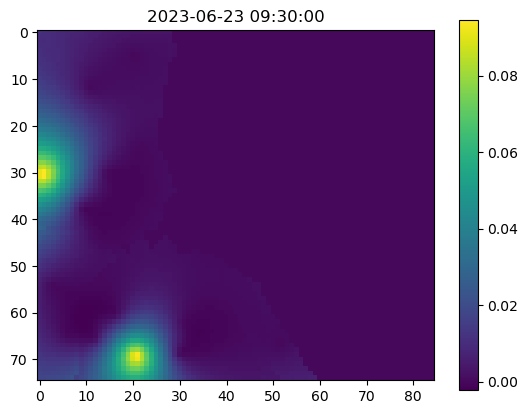

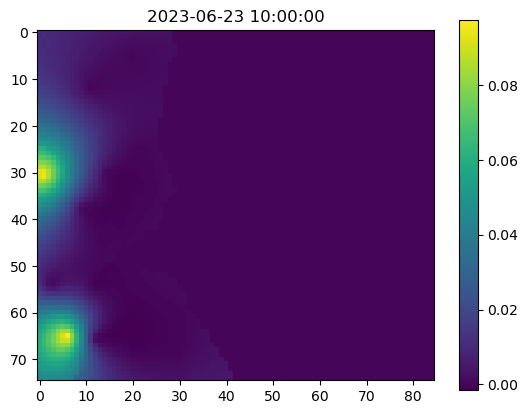

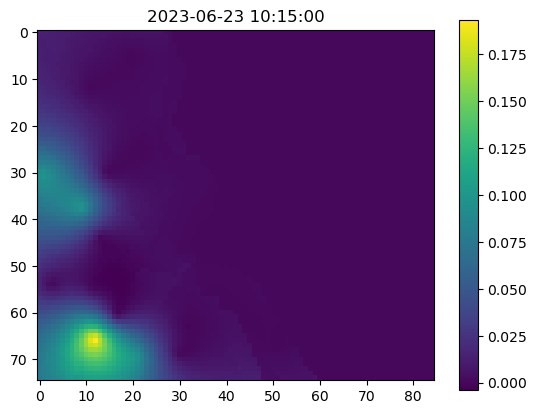

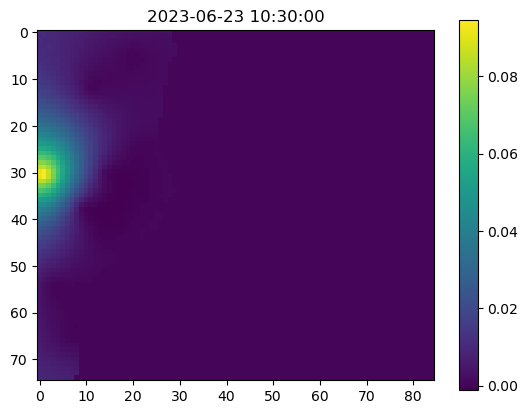

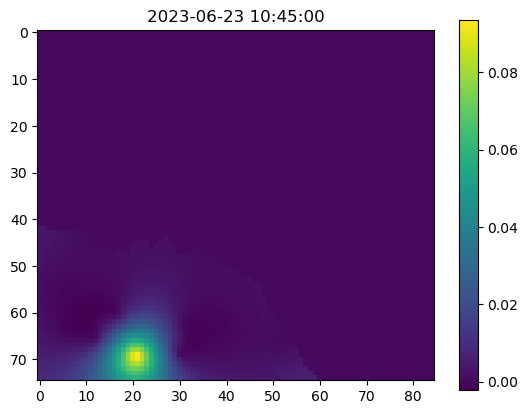

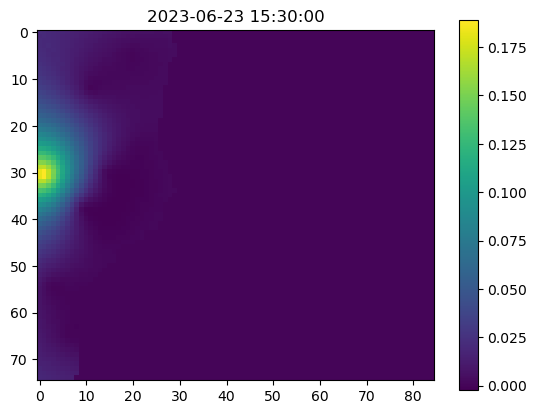

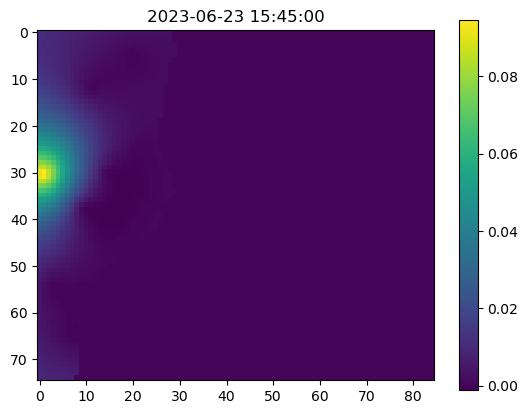

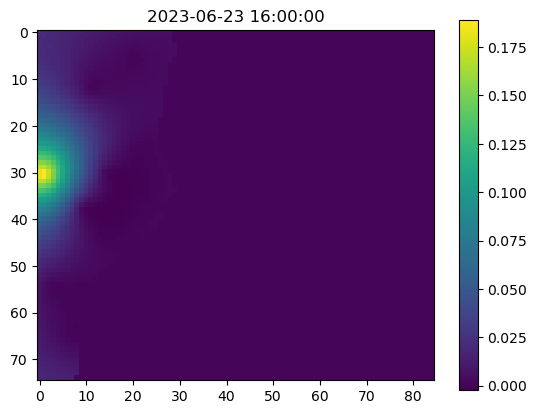

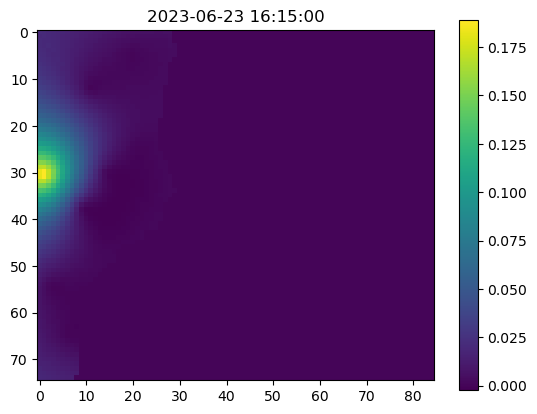

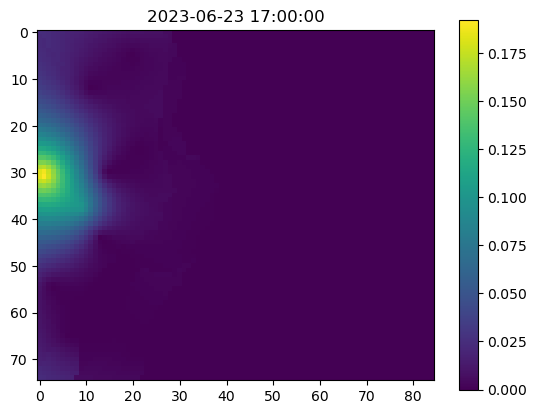

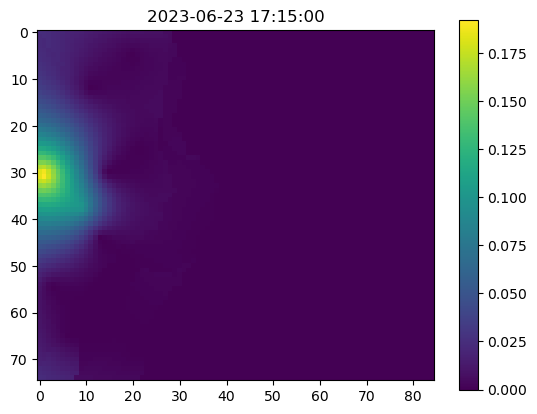

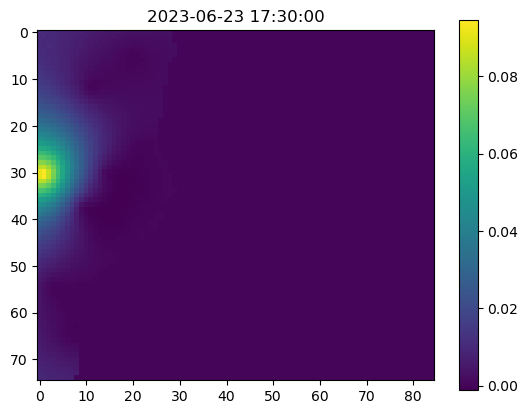

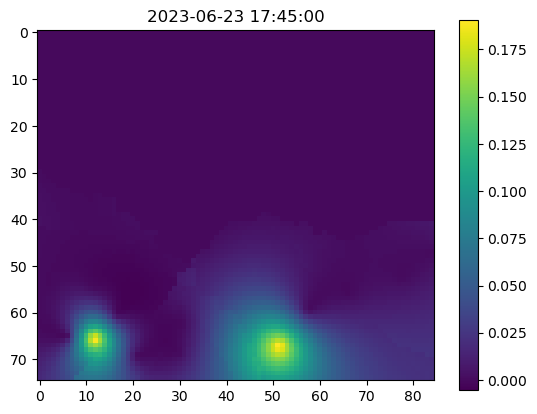

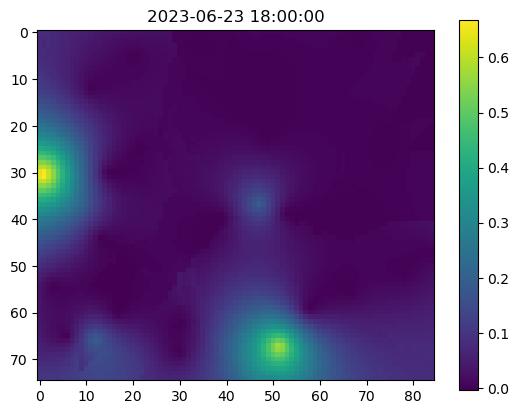

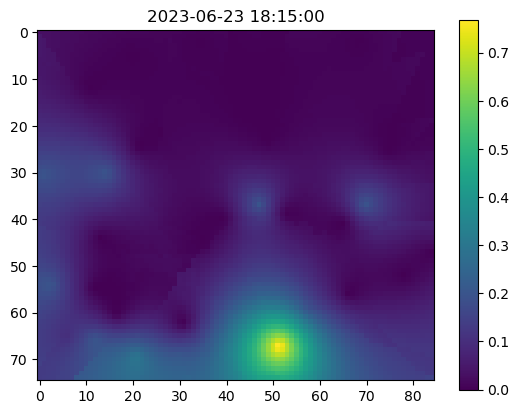

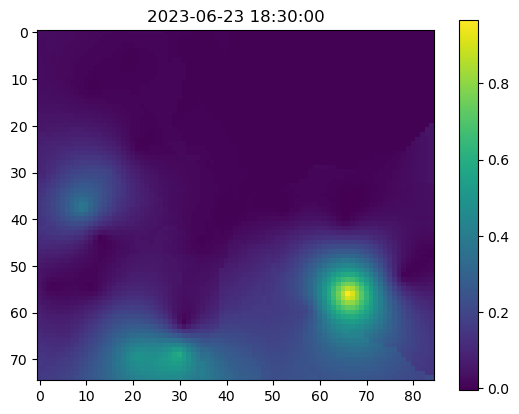

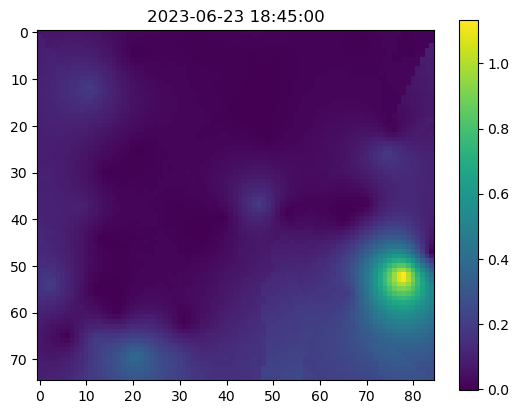

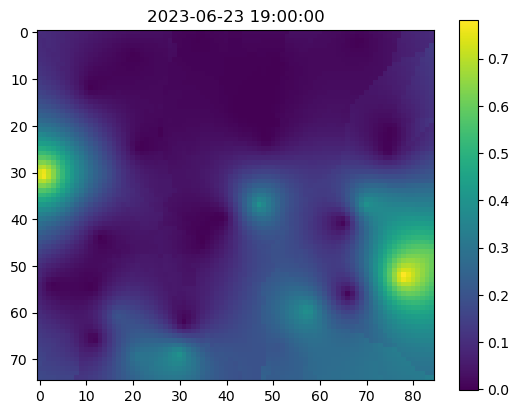

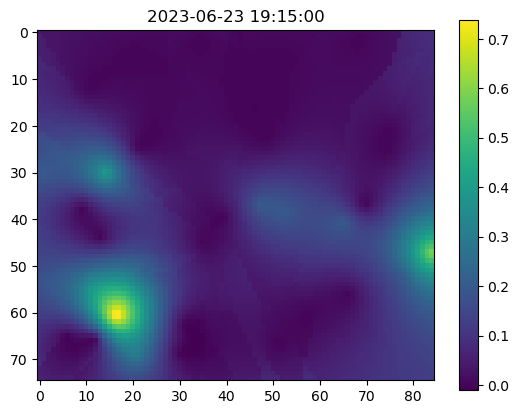

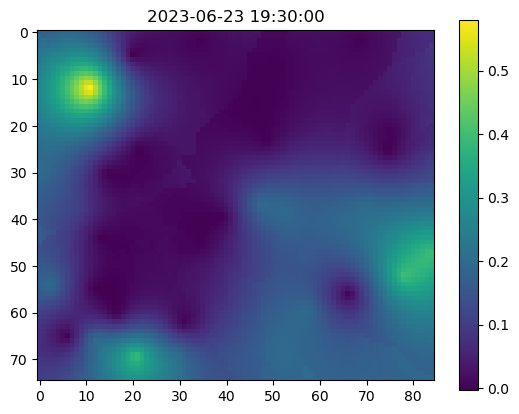

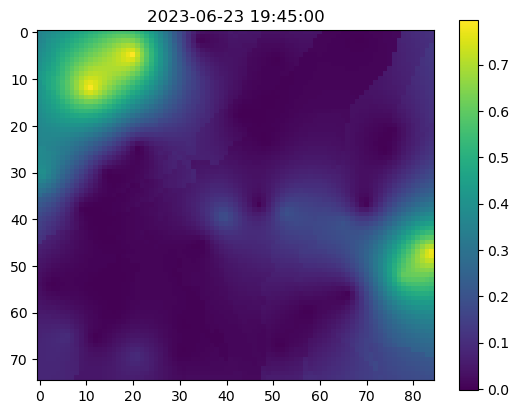

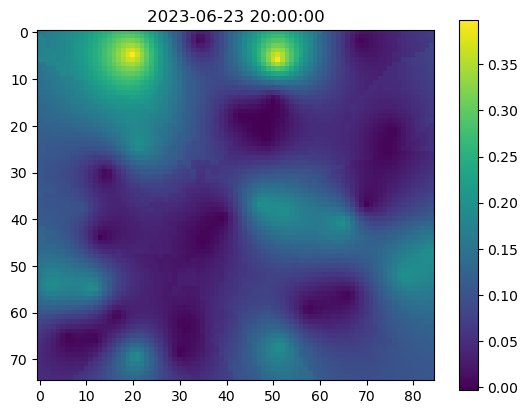

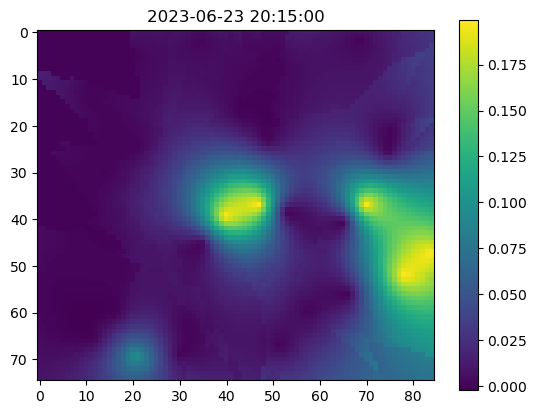

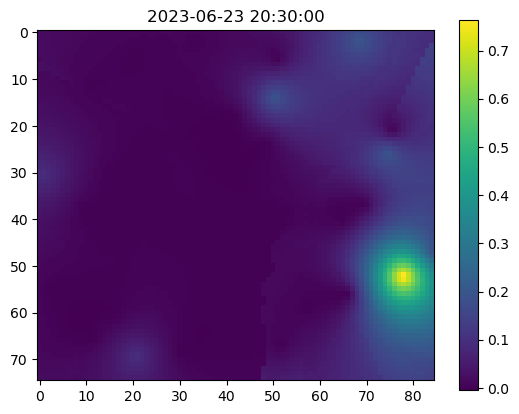

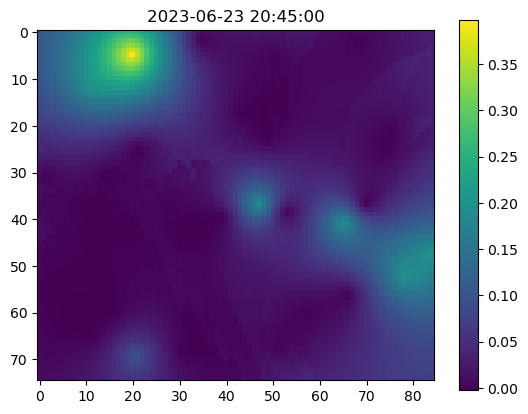

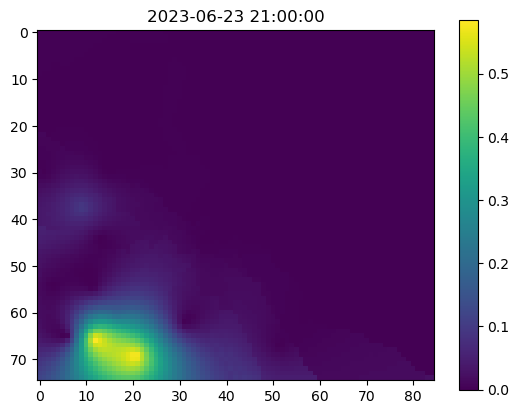

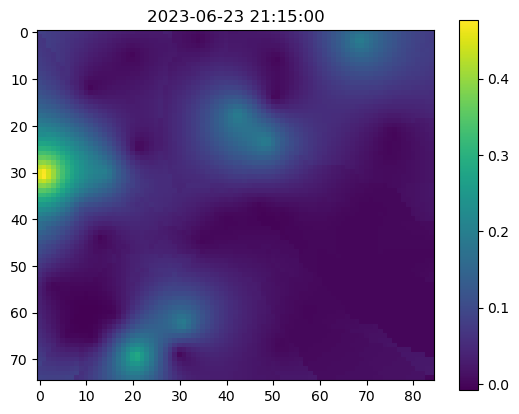

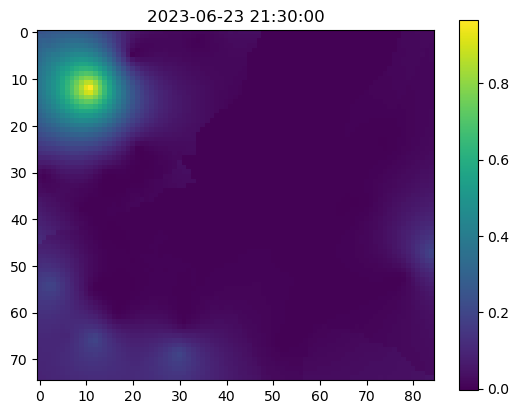

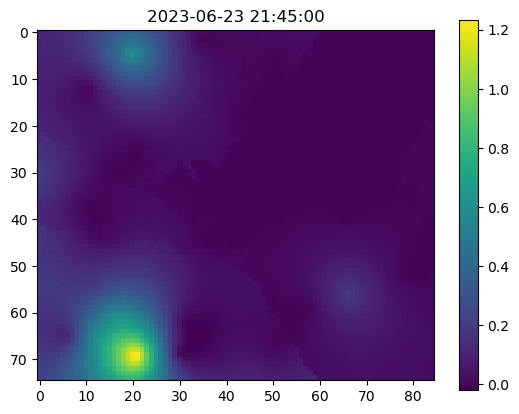

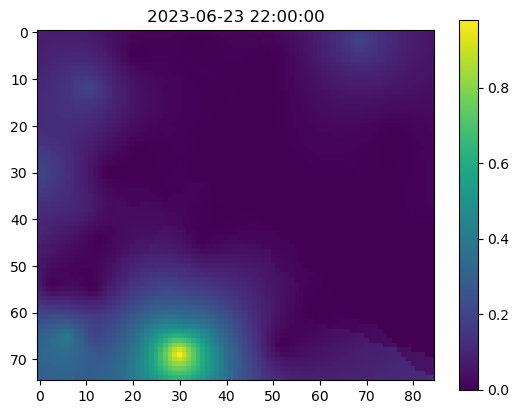

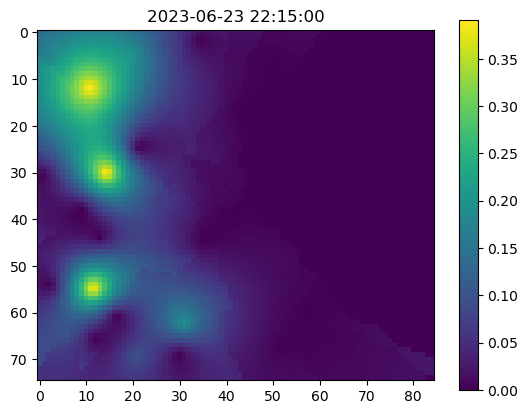

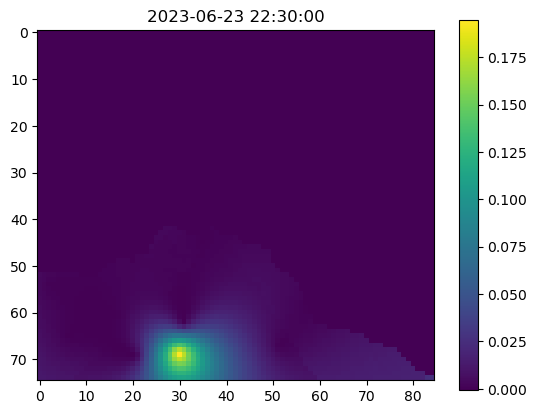

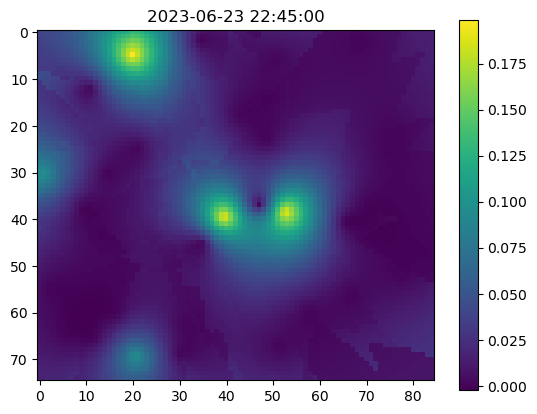

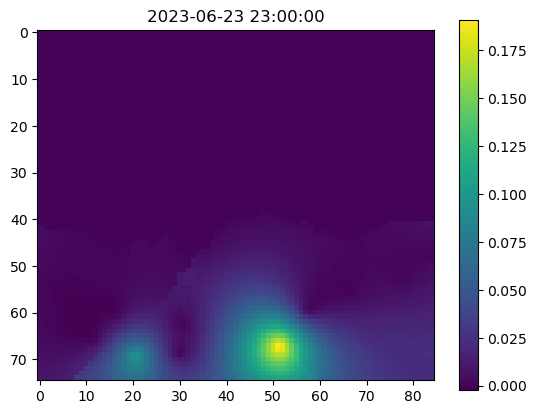

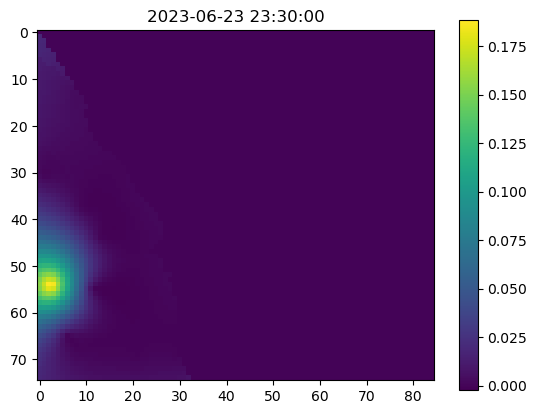

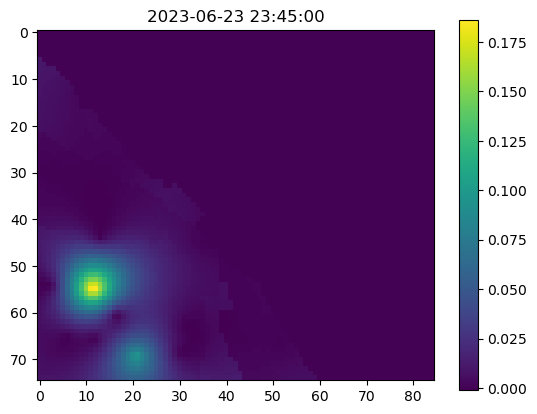

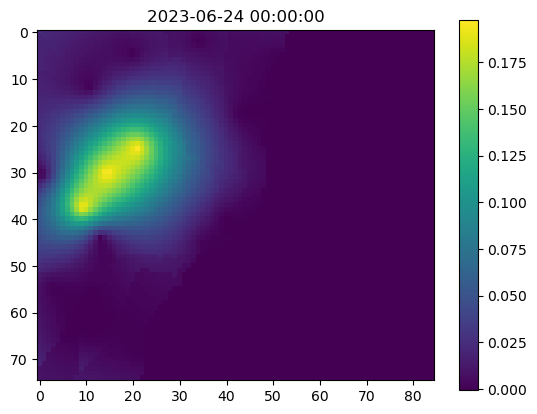

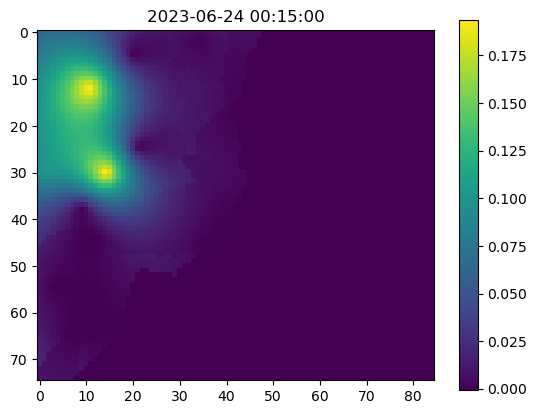

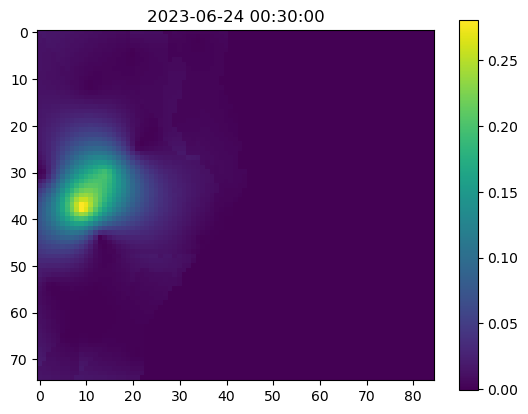

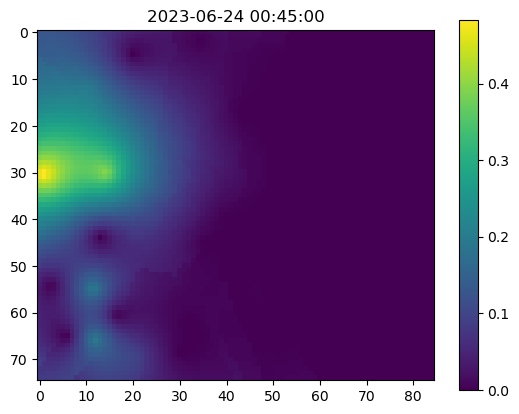

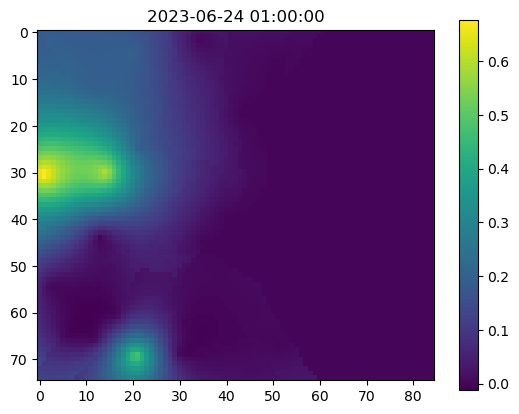

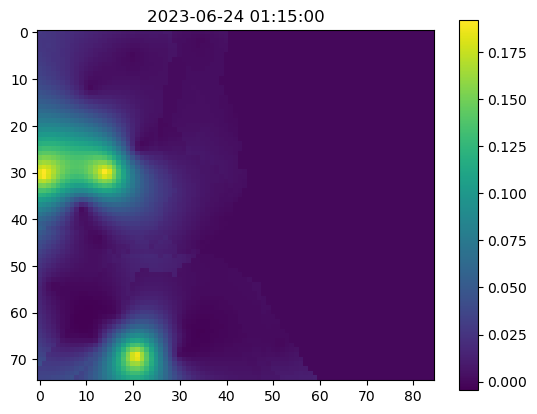

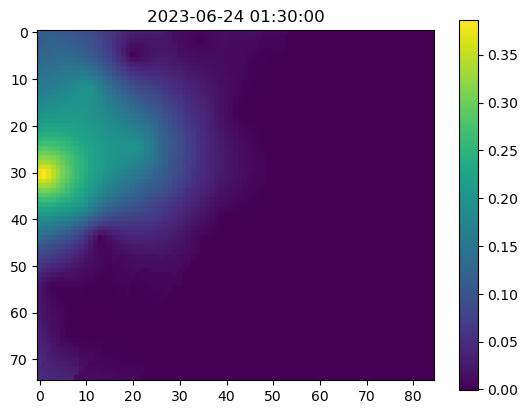

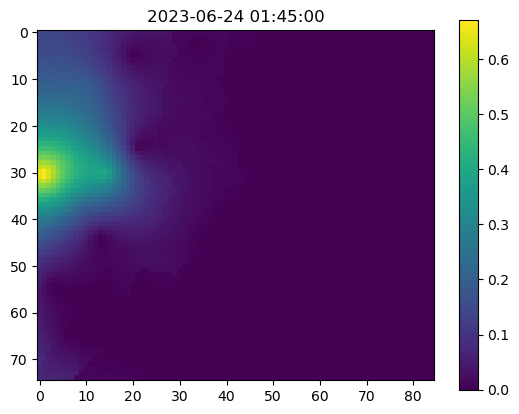

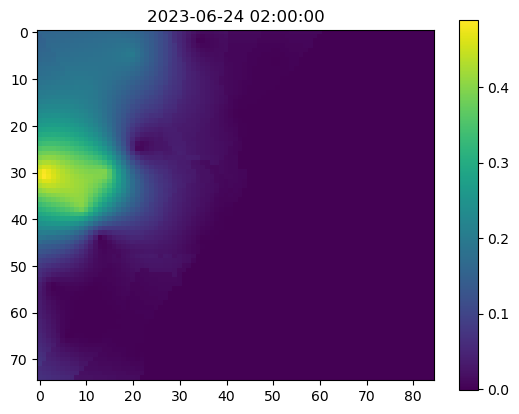

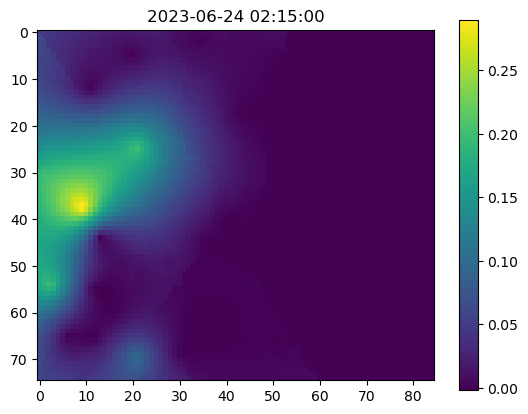

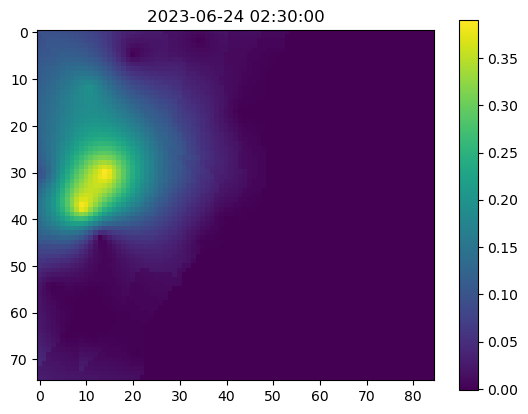

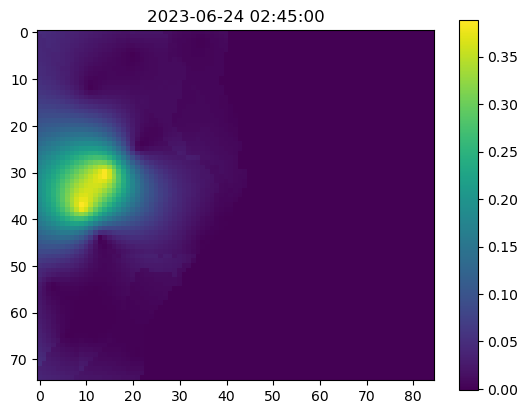

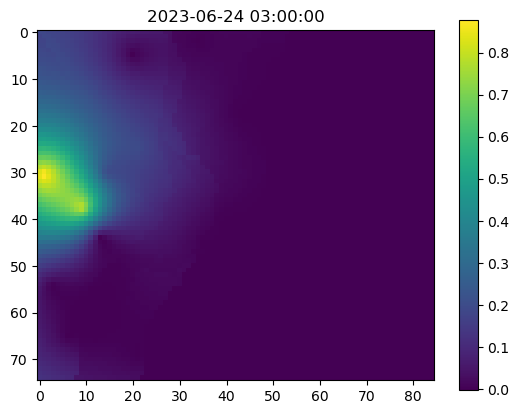

In [ ]:
for i in range(gridded.shape[0]):
    if (np.nansum(gridded[i]) > 0) & (~np.isnan(np.nansum(gridded[i]))):
        plt.imshow(gridded[i])
        plt.title(new_index[i])
        plt.colorbar()
        plt.show()

In [ ]:
np.save(join(gridded_outpath, "gridded.npy"), gridded)
#np.save(join(join(gauge_path, "gridded"), "EA_UO_gauges_cov.npy"), gridded_EA_UO)